# Assignment 2
## 1. Setup & Imports
Importing the required libraries

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.integrate import odeint
import seaborn as sns

In [4]:
import matplotlib as mpl

sns.set_theme() 
mpl.rcParams["font.family"] = "DejaVu Sans"   # fix for font


### 1. Function(s) Implementation

In [6]:
def sird_model(y, t, beta, gamma, mu):
    """
    SIRD model:

    S = Susceptibles
    I = Infected
    R = Recovered
    D = Deaths
    
    """
    S, I, R, D = y  
    N = S + I + R + D

    dSdt = -1 * beta * S * I / N
    dIdt = (beta * S * I / N) - (gamma * I) - (mu * I)
    dRdt = gamma * I
    dDdt = mu * I

    return dSdt, dIdt, dRdt, dDdt

In [7]:
def analyze_recovery_rates(beta, mu, N, I0, simulation_days):
    """
    Analyze epidemic outcomes for different recovery rates.

    Parameters:
    -----------
    beta : float
        Transmission rate
    mu : float  
        Mortality rate
    N : int
        Total population
    I0 : int
        Initial infected individuals
    simulation_days : int
        Simulation duration in days

    Returns:
    --------
    pandas.DataFrame
        Results summary for each recovery rate
    """

    # Gamma values to test
    gamma_values = [0.05, 0.1, 0.15, 0.2, 0.25]

    # Set up initial conditions with 4 compartments
    S0 = N - I0
    R0 = 0
    D0 = 0
    y0 = [S0, I0, R0, D0]

    # Time points
    t = np.linspace(0, simulation_days, simulation_days)

    results_list = []
    simulation_results = {}

    # Plot setup
    fig, ax = plt.subplots(figsize=(12, 8))

    # Loop through each gamma value and run the simulation
    for gamma in gamma_values:
        
        # Solve SIRD equations
        sol = odeint(sird_model, y0, t, args=(beta, gamma, mu))
        S, I, R, D = sol.T
        
        # Calculate metrics
        # Basic Reproduction Number
        r_zero = beta / gamma 
        
        # Peak number of infected individuals and the day it occurs
        peak_infected = np.max(I)
        peak_day = np.argmax(I)
        
        # Total deaths at the end of the simulation
        total_deaths = D[-1]

        results_list.append({
            'gamma': gamma,
            'R0': round(r_zero, 2),
            'peak_infected': int(peak_infected),
            'peak_day': peak_day,
            'total_deaths': int(total_deaths)
        })

        # Add the infection curve for the current gamma to the plot
        ax.plot(t, I, label=f'γ = {gamma} (R₀ = {r_zero:.2f})')

    # Finalizing Plot
    ax.set_title('Impact of Recovery Rate (γ) on Infected Population', fontsize=16)
    ax.set_xlabel('Days', fontsize=12)
    ax.set_ylabel('Number of Infected Individuals', fontsize=12)
    ax.legend(title='Recovery Rate (γ) & R₀')
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    
    # Create the results DataFrame
    results_df = pd.DataFrame(results_list)

    return results_df, fig

### 1. Code Execution

,gamma,R0,peak_infected,peak_day,total_deaths
0,0.05,6.0,477900,54,165503
1,0.10,3.0,265192,64,83479
2,0.15,2.0,131371,80,47442
3,0.20,1.5,50328,112,25381
4,0.25,1.2,9320,207,9749


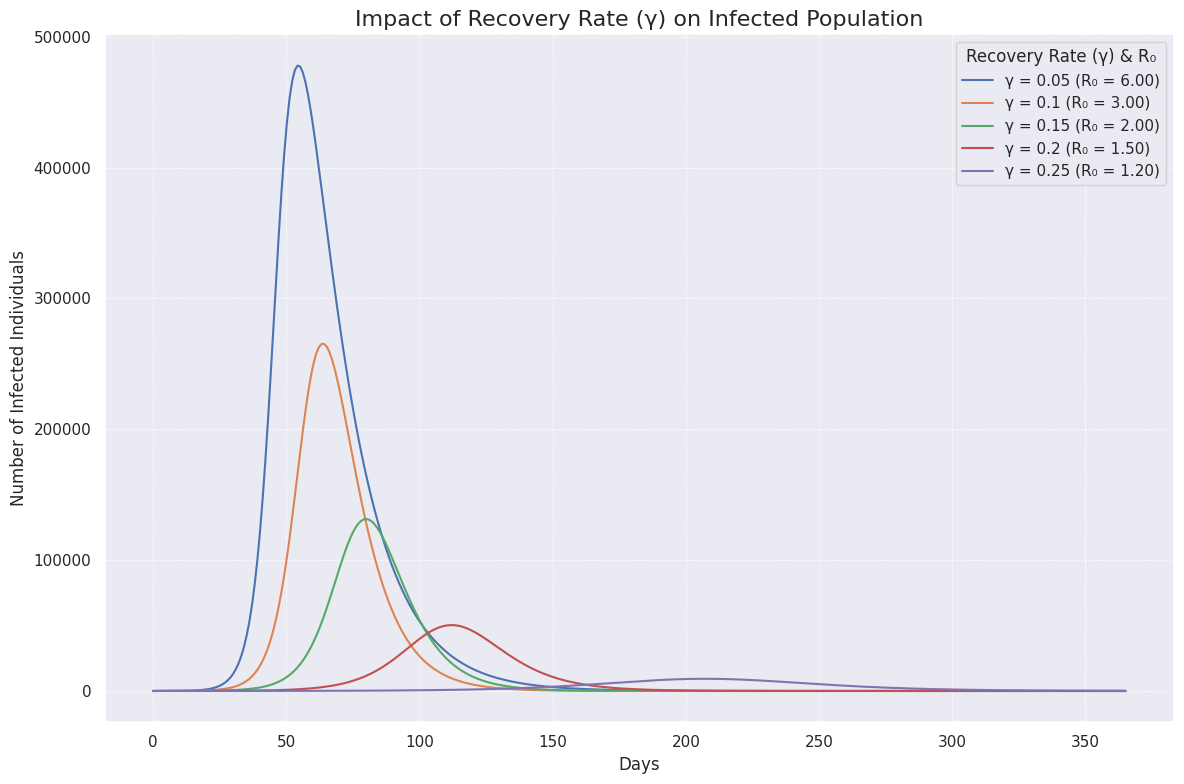

In [9]:
# Define model parameters
BETA = 0.3 # Transmission rate
MU = 0.01 # Mortality rate
N_POPULATION = 1_000_000 # Total population
I0_INITIAL = 10 # Initial infected
SIMULATION_DAYS = 365 # Duration of simulation

# Run the analysis
summary_df, figure = analyze_recovery_rates(
    beta=BETA,
    mu=MU,
    N=N_POPULATION,
    I0=I0_INITIAL,
    simulation_days=SIMULATION_DAYS
)

summary_df

# 2. Scenario comparison

scenario A // high transmission / first graph


,gamma,R0,peak_infected,peak_day,total_deaths
0,0.05,8.00,520,21,284
1,0.10,4.00,340,22,159
2,0.15,2.67,213,24,102
3,0.20,2.00,123,27,67
4,0.25,1.60,63,30,42


scenario B // low transmission / second graph


,gamma,R0,peak_infected,peak_day,total_deaths
0,0.05,4.00,371,44,88
1,0.10,2.00,139,52,36
2,0.15,1.33,31,67,13
3,0.20,1.00,5,0,1
4,0.25,0.80,5,0,0


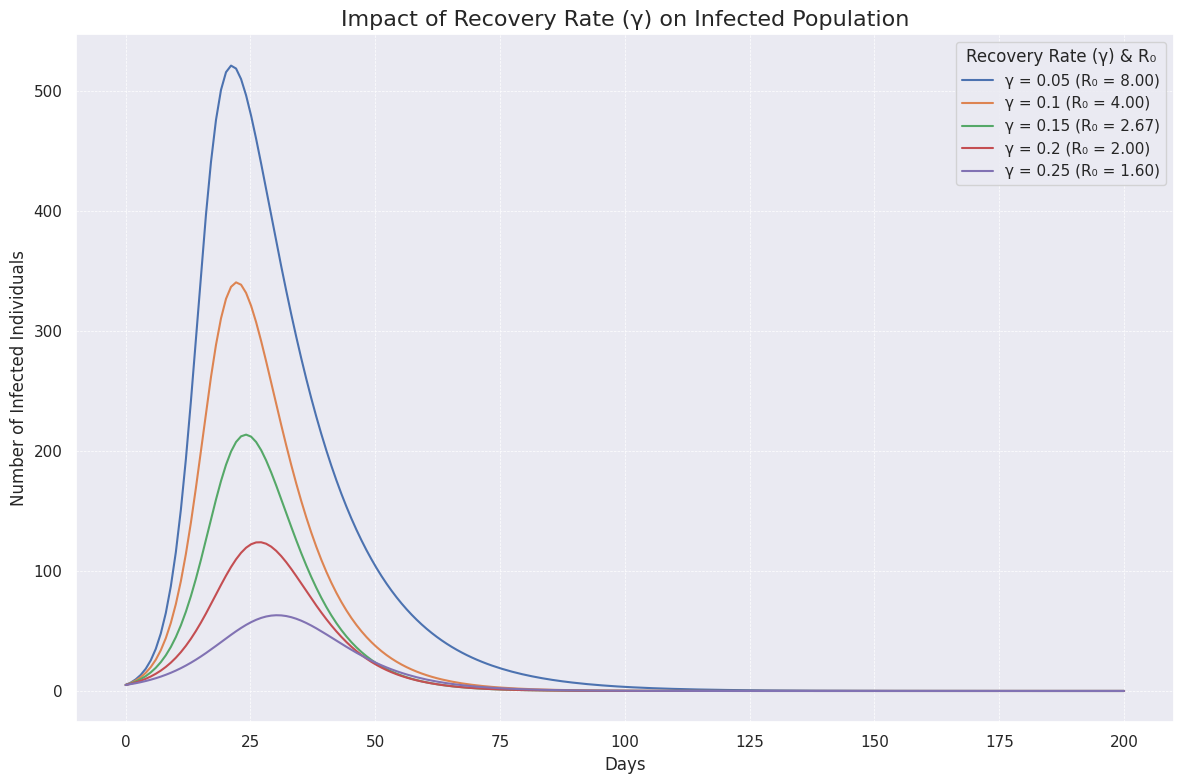

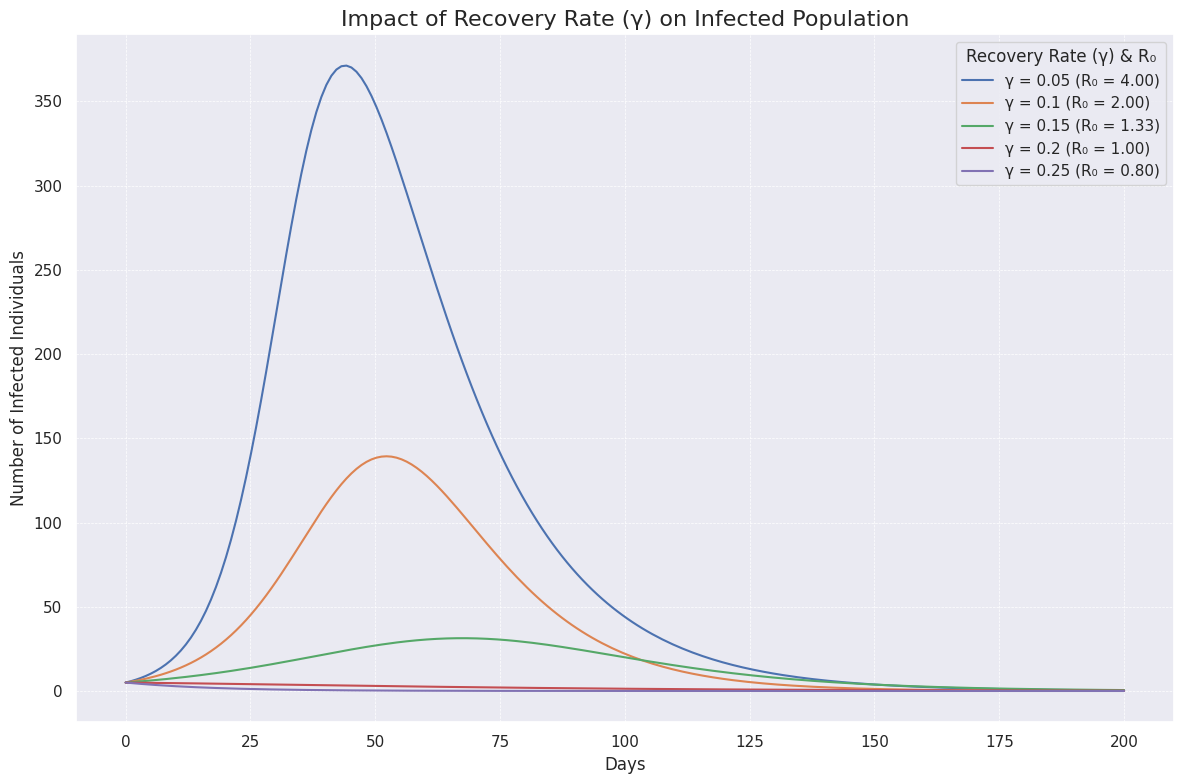

In [16]:
#scenario A // high transmission
params_A = dict(beta=0.4, mu=0.02, N=1000, I0=5, simulation_days=200)

#scenario B // low transmission
params_B = dict(beta=0.2, mu=0.005, N=1000, I0=5, simulation_days=200)




#we run the function from part 1 with these new parameters
resA = analyze_recovery_rates(**params_A)
resB = analyze_recovery_rates(**params_B)

if isinstance(resA, tuple):
    results_A, fig_A = resA
else:
    results_A, fig_A = resA, None

if isinstance(resB, tuple):
    results_B, fig_B = resB
else:
    results_B, fig_B = resB, None




#tables and graphs 
results_A = results_A.sort_values("gamma").reset_index(drop=True)
results_B = results_B.sort_values("gamma").reset_index(drop=True)

print("scenario A // high transmission / first graph")
display(results_A)

print("scenario B // low transmission / second graph")
display(results_B)


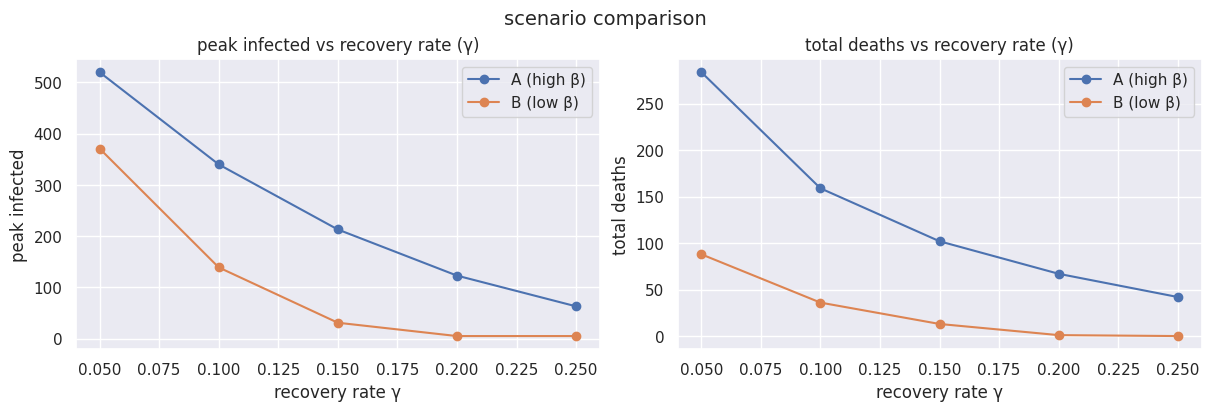

In [17]:
#our results
A = results_A.assign(scenario="A (high β)")
B = results_B.assign(scenario="B (low β)")
both = pd.concat([A, B], ignore_index=True)


fig, axes = plt.subplots(1, 2, figsize=(12, 4), constrained_layout=True)



#peak infected vs gamma
for label, df in both.groupby("scenario"):
    axes[0].plot(df["gamma"], df["peak_infected"], marker="o", label=label)
axes[0].set_title("peak infected vs recovery rate (γ)")
axes[0].set_xlabel("recovery rate γ")
axes[0].set_ylabel("peak infected")
axes[0].legend()


#total deaths vs gamma
for label, df in both.groupby("scenario"):
    axes[1].plot(df["gamma"], df["total_deaths"], marker="o", label=label)
axes[1].set_title("total deaths vs recovery rate (γ)")
axes[1].set_xlabel("recovery rate γ")
axes[1].set_ylabel("total deaths")
axes[1].legend()




fig.suptitle("scenario comparison", fontsize=14)
plt.show()

In [20]:
#summary plus analysis for our conclusion 


def summarize_pair(a: pd.DataFrame, b: pd.DataFrame):
    s = {}
    s["avg_peak_A"] = a["peak_infected"].mean()
    s["avg_peak_B"] = b["peak_infected"].mean()
    s["avg_deaths_A"] = a["total_deaths"].mean()
    s["avg_deaths_B"] = b["total_deaths"].mean()
    s["worse_peak"] = "A (high β)" if s["avg_peak_A"] > s["avg_peak_B"] else "B (low β)"
    s["worse_deaths"] = "A (high β)" if s["avg_deaths_A"] > s["avg_deaths_B"] else "B (low β)"
    return s

summary = summarize_pair(results_A, results_B)


print("scenario comparison")
print(f"average peak infected — A: {summary['avg_peak_A']:.1f}, B: {summary['avg_peak_B']:.1f}  → worse: {summary['worse_peak']}")
print(f"average total deaths — A: {summary['avg_deaths_A']:.1f}, B: {summary['avg_deaths_B']:.1f}  → worse: {summary['worse_deaths']}")


scenario comparison
average peak infected — A: 251.8, B: 110.2  → worse: A (high β)
average total deaths — A: 130.8, B: 27.6  → worse: A (high β)


### scenario comparison

**Which scenario is worse?**  
Scenario A (High transmission // β) consistently shows higher peak infections and higher total deaths across γ values than Scenario B (Low β). Increasing the recovery rate (γ) reduces both peak size and deaths in both scenarios but the high transmission scenario remains worse overall because β is larger which raises R₀ = β/γ for every γ.

Higher β increases R₀ and this leads to faster and larger outbreaks before recovery can catch up. Even when γ increases, the network level effect of higher transmission keeps Scenario A peaks and deaths above Scenario B.


# 3. Policy recommendtation

First let's look at the dataframes of both scenarios

In [22]:
print("scenario A // high transmission / first graph")
display(results_A)

print("scenario B // low transmission / second graph")
display(results_B)

scenario A // high transmission / first graph


,gamma,R0,peak_infected,peak_day,total_deaths
0,0.05,8.00,520,21,284
1,0.10,4.00,340,22,159
2,0.15,2.67,213,24,102
3,0.20,2.00,123,27,67
4,0.25,1.60,63,30,42


scenario B // low transmission / second graph


,gamma,R0,peak_infected,peak_day,total_deaths
0,0.05,4.00,371,44,88
1,0.10,2.00,139,52,36
2,0.15,1.33,31,67,13
3,0.20,1.00,5,0,1
4,0.25,0.80,5,0,0


In both scenarios we can see some trends. As we increase the recovery rate the peak amount of infected people start to drop, and in turn the total deaths also drop (example: scenario A row 0 to row 2, as we increase gamma from 0.05 to 0.1 and 0.15 the peak_infected drops from 520 to 340 then 213), on the other hand the peak day of infection gets further and further (in the example 21 to 22 then 24 days) since the higher recovery rate will result in less infection causing the epidemic to linger.

In [41]:
def analyze_recovery_rates_no_plot(gamma_values,beta, mu, N, I0, simulation_days):
    """
    Analyze epidemic outcomes for different recovery rates.

    Parameters:
    -----------
    beta : float
        Transmission rate
    mu : float  
        Mortality rate
    N : int
        Total population
    I0 : int
        Initial infected individuals
    simulation_days : int
        Simulation duration in days

    Returns:
    --------
    pandas.DataFrame
        Results summary for each recovery rate
    """


    # Set up initial conditions with 4 compartments
    S0 = N - I0
    R0 = 0
    D0 = 0
    y0 = [S0, I0, R0, D0]

    # Time points
    t = np.linspace(0, simulation_days, simulation_days)

    results_list = []
    simulation_results = {}


    # Loop through each gamma value and run the simulation
    for gamma in gamma_values:
        
        # Solve SIRD equations
        sol = odeint(sird_model, y0, t, args=(beta, gamma, mu))
        S, I, R, D = sol.T
        
        # Calculate metrics
        # Basic Reproduction Number
        r_zero = beta / gamma 
        
        # Peak number of infected individuals and the day it occurs
        peak_infected = np.max(I)
        peak_day = np.argmax(I)
        
        # Total deaths at the end of the simulation
        total_deaths = D[-1]

        results_list.append({
            'gamma': gamma,
            'R0': round(r_zero, 2),
            'peak_infected': int(peak_infected),
            'peak_day': peak_day,
            'total_deaths': int(total_deaths)
        })

        # Add the infection curve for the current gamma to the plot

    # Finalizing Plot
    
    # Create the results DataFrame
    results_df = pd.DataFrame(results_list)

    return results_df

Now we are going to see what happens if an intervention increases the recovery rate by 50% We are assuming a worst case peak infection from A, in this case 520 infected, then we are gonna see how the intervention affects it.

In [43]:
# using scenario A with high transmission rate
params_A = dict(gamma_values = [0.05, 0.1, 0.15, 0.2, 0.25],beta=0.4, mu=0.02, N=1000, I0=5, simulation_days=200)
params_A2 = dict(gamma_values = [0.55, 0.6, 0.65, 0.7, 0.75],beta=0.4, mu=0.02, N=1000, I0=520, simulation_days=200)
resA = analyze_recovery_rates_no_plot(**params_A)
resB = analyze_recovery_rates_no_plot(**params_A2)
print(resA)
print(resB)


   gamma    R0  peak_infected  peak_day  total_deaths
0   0.05  8.00            520        21           284
1   0.10  4.00            340        22           159
2   0.15  2.67            213        24           102
3   0.20  2.00            123        27            67
4   0.25  1.60             63        30            42
   gamma    R0  peak_infected  peak_day  total_deaths
0   0.55  0.73            520         0            24
1   0.60  0.67            520         0            22
2   0.65  0.62            520         0            20
3   0.70  0.57            520         0            18
4   0.75  0.53            520         0            17


Peak day 0 for the second table just means that the intervention caused the epidemic to slow down from its peak. We can see that the mortality rates drop by respectively: 91.55% 86.16% 80.39% 73.13% 59.52% (calculated by (deaths before - deaths after intervention )/ deaths before  multiplied by 100 to get a percentage).

Vaccines could cause an increase in recovery rates. It would certainly reduce the total amount of deaths, however by itself it would push the duration of the epidemic out because the amount of infected people will also be less. To counter this we would need some other prevention (like isolation) to also mitigate the infection rates, since the vaccine by itself does not change that.